### Exercise 10

Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10 if you want a bigger challenge. Regardless of the dataset you’re using, follow these steps:

1. Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.

2. Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.

3. Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

Let's use MNIST:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# GPU training is unreliable on Mac
tf.config.set_visible_devices([], 'GPU')

In [3]:
# loads, scales, and splits the MNIST dataset
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [5]:
# Train the autoencoder

denoise_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianNoise(stddev=1.0, seed=42),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
denoise_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
denoise_ae = tf.keras.Sequential([denoise_encoder, denoise_decoder])

# extra code – compiles and fits the model
denoise_ae.compile(loss="mse", optimizer="nadam")
history = denoise_ae.fit(X_train, X_train, epochs=50,
                        validation_data=(X_valid, X_valid))

Epoch 1/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0476 - val_loss: 0.0344
Epoch 2/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0398 - val_loss: 0.0321
Epoch 3/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0382 - val_loss: 0.0310
Epoch 4/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0375 - val_loss: 0.0302
Epoch 5/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0298
Epoch 6/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0365 - val_loss: 0.0295
Epoch 7/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0360 - val_loss: 0.0289
Epoch 8/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0357 - val_loss: 0.0285
Epoch 9/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0355 - val_loss: 0.0289
Epoch 10/50
1719/1719 [==============================] - 3s 2ms/step - loss: 0.035

In [6]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstrunctions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstrunctions[image_index], cmap="binary")
        plt.axis("off")

1/1 [==============================] - 0s 11ms/step


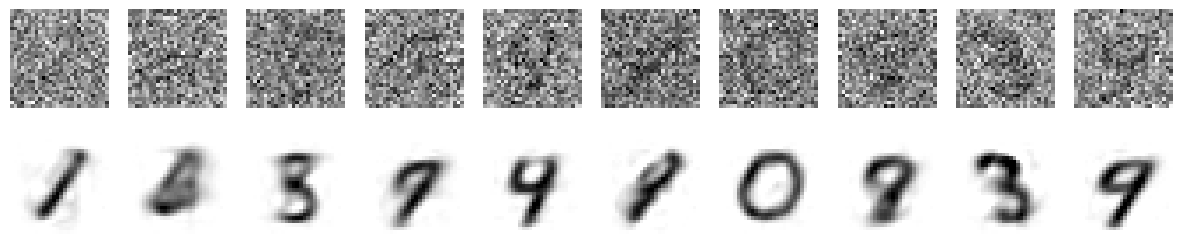

In [8]:
noise = tf.keras.layers.GaussianNoise(stddev=1.0, seed=42)
# we pass images through noise layer because the noise layer in the denoise_ae model is only active during training
plot_reconstructions(denoise_ae, noise(X_valid, training=True), n_images=10)

Now let's train a classifier!

In [13]:
mnist_classifier = tf.keras.Sequential([
    denoise_encoder,
    tf.keras.layers.Dense(10, activation="softmax")
])

for layer in denoise_encoder.layers:
    layer.trainable = False

mnist_classifier.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                         metrics=["accuracy"])

history = mnist_classifier.fit(X_train[:500], y_train[:500],
                               validation_data=(X_valid, y_valid), epochs=500)

Epoch 1/500
16/16 [==============================] - 0s 9ms/step - loss: 3.1794 - accuracy: 0.1840 - val_loss: 2.9630 - val_accuracy: 0.1760
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 2.9359 - accuracy: 0.1840 - val_loss: 2.7726 - val_accuracy: 0.1750
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 2.7355 - accuracy: 0.2040 - val_loss: 2.6098 - val_accuracy: 0.1796
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 2.6304 - accuracy: 0.1920 - val_loss: 2.4689 - val_accuracy: 0.1908
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 2.4620 - accuracy: 0.1900 - val_loss: 2.3478 - val_accuracy: 0.2004
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 2.3336 - accuracy: 0.1940 - val_loss: 2.2456 - val_accuracy: 0.2172
Epoch 7/500
16/16 [==============================] - 0s 5ms/step - loss: 2.2719 - accuracy: 0.2320 - val_loss: 2.1553 - val_accuracy: 0.2340
Epoch 8/500
1

Validation accuracy 85%! Not bad for training with only 500 images...

now let's unfreeze the lower layers and train for a few more epochs:

In [14]:
for layer in denoise_encoder.layers:
    layer.trainable = True

mnist_classifier.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
                         metrics=["accuracy"])

history = mnist_classifier.fit(X_train[:500], y_train[:500],
                               validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
16/16 [==============================] - 0s 9ms/step - loss: 0.6751 - accuracy: 0.7840 - val_loss: 0.4637 - val_accuracy: 0.8652
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6499 - accuracy: 0.7880 - val_loss: 0.4360 - val_accuracy: 0.8778
Epoch 3/20
16/16 [==============================] - 0s 6ms/step - loss: 0.6264 - accuracy: 0.7780 - val_loss: 0.4187 - val_accuracy: 0.8842
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6347 - accuracy: 0.8040 - val_loss: 0.4071 - val_accuracy: 0.8944
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6107 - accuracy: 0.8160 - val_loss: 0.3924 - val_accuracy: 0.8936
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.6067 - accuracy: 0.8040 - val_loss: 0.3840 - val_accuracy: 0.8974
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 0.5752 - accuracy: 0.8240 - val_loss: 0.3888 - val_accuracy: 0.8936
Epoch 8/20
16/16 [==

Even better!

In [15]:
mnist_classifier.evaluate(X_test, y_test)

313/313 [==============================] - 0s 434us/step - loss: 0.3984 - accuracy: 0.8804


[0.3984350562095642, 0.8804000020027161]

### Exercise 11

Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

Let's continue with the mnist dataset. Building the variational autoencoder is exactly like we did in the code along notebook. First the Sampling layer:

In [16]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

Next, the encoder. Note that the Sampling layer is part of the encoder. So the latent loss is measured after the Sampling layer and penalizes the model if the distribution of its output differs significantly from Gaussian noise.

In [17]:
codings_size = 15

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z) # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

Next the decoder. Can we try to use the Sequential API this time?

In [19]:
variational_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[codings_size]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])

In [29]:
_, _, codings = variational_encoder(inputs)
reconstrunctions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstrunctions])

In [30]:
variational_ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 model (Functional)          [(None, 15),              135880    
                              (None, 15),                        
                              (None, 15)]                        
                                                                 
 sequential_10 (Sequential)  (None, 28, 28)            135134    
                                                                 
Total params: 271014 (1.03 MB)
Trainable params: 271014 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Looks exactly like the code along notebook model. Now let's add the loss, compile and train the model:

In [31]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1
)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,
                                validation_data=(X_valid, X_valid))

Epoch 1/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0374 - val_loss: 0.0374
Epoch 2/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0374 - val_loss: 0.0373
Epoch 3/50
430/430 [==============================] - 2s 5ms/step - loss: 0.0374 - val_loss: 0.0373
Epoch 4/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0373
Epoch 5/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0373
Epoch 6/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0373
Epoch 7/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0372
Epoch 8/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0372
Epoch 9/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0373
Epoch 10/50
430/430 [==============================] - 2s 4ms/step - loss: 0.0373 - val_loss: 0.0372

Let's inspect visually the reconstrunctions:

1/1 [==============================] - 0s 52ms/step


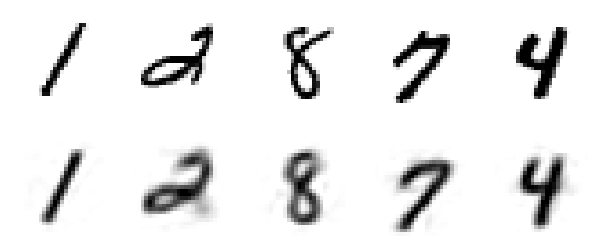

In [32]:
plot_reconstructions(variational_ae)

Now let's generate some new images:

In [33]:
# Mean and std can be anything we like
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

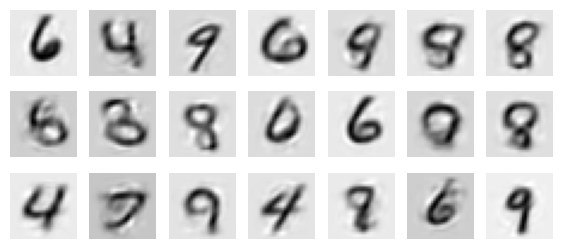

In [34]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)